# Removing the season and trend-components of a time series

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#### Loading and pre-processing data

In [2]:
df = pd.read_csv("Data/monthly_in_situ_co2_mlo.csv",skiprows=55) # Leser inn data

df["Dato"] = df["Yr"].map(str) + "-" +df["Mn"].map(str) # Lager ny dato kolonne med format YYYY-MM
df.Dato = pd.to_datetime(df['Dato'], format='%Y-%m') # Bytter dato til pandas-datetime format
df.set_index(['Dato'],inplace=True) #Setter dato som index
df = df.rename({"CO2[ppm]": 'CO2'}, axis=1)  # Lager nytt navn for C02-konsentrasjon kolonne

df = df[["CO2"]] # Trenger bare disse verdiene

#Håndterer manglende data
df = df.iloc[12:-12]
df.loc[(df.CO2 == -99.99),'CO2']=320.92

Kode for å plotte dataframe

In [ ]:
def plot_df(df, x, y, title="", xlabel='Dato', ylabel='CO2[ppm]'):
    
    plt.figure(figsize=(16,8))
    plt.plot(x, y,linestyle="-")
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

#### Resultater statsmodels

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['CO2'], model='additive', extrapolate_trend='freq', freq=12)

In [73]:
m = result.trend.values

In [74]:
df1 = df.copy(deep=True)
df1.CO2 = m

In [75]:
df2 = df1.reset_index(drop=True)
y = df2.CO2.values
X = df2.index.values

In [76]:
X = X.reshape(-1,1)

poly = PolynomialFeatures(2)
X2 = poly.fit_transform(X)

reg = LinearRegression().fit(X2, y)
reg.score(X2,y)

0.9994443504057992

In [77]:
pred = reg.intercept_ + (np.dot(X2, reg.coef_))
diff = (pred - y)

In [78]:
np.mean(diff)

1.8237263551175906e-14

In [79]:
dfz = df1.copy(deep=True)
dfz.CO2 = diff

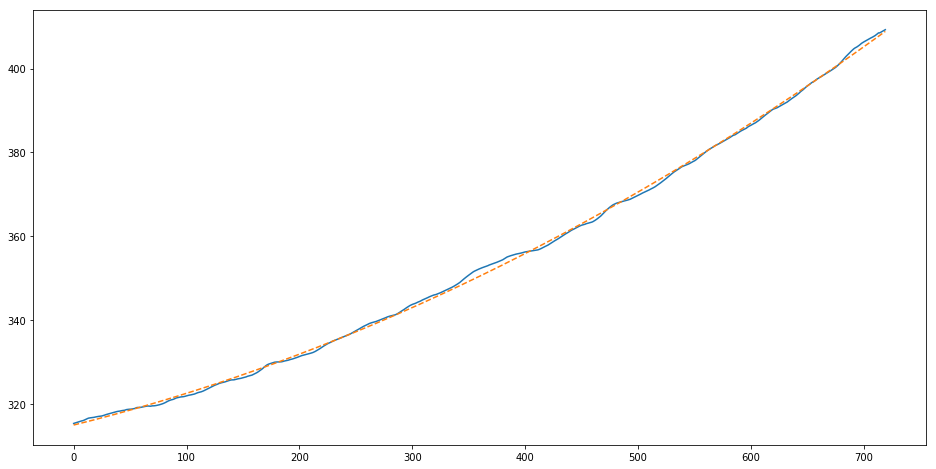

In [80]:
plt.figure(figsize=(16,8))
plt.plot(X, y,linestyle="-")
plt.plot(X, pred,linestyle="--")
plt.show()

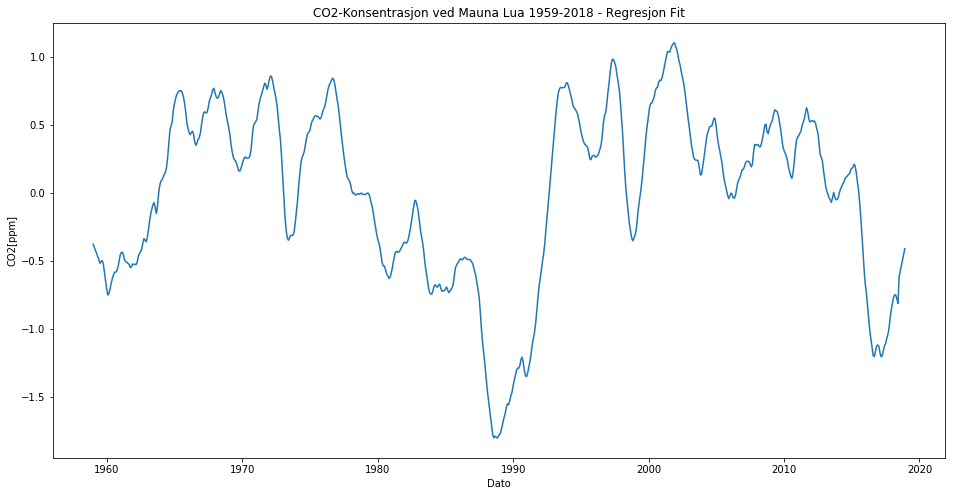

In [81]:
plot_df(dfz, x=dfz.index, y=dfz.CO2, title='Residualer') 

#### Estemering av trend-komponent

In [3]:
n = len(df.index) #antall data-punkter
q = 6
x = np.pad(df.CO2.values, q, 'edge')

m = np.zeros(n)

for i in range(n):
    
    for j in range(-q,q+1):
        
        if (j == -q or j == q):
            k = 0.5
        else:
            k = 1

        m[i] += k*x[q+i-j]
    
    m[i] = m[i]/(2*q)

df1 = df.copy(deep=True)
df1.CO2 = m

In [4]:
df2 = df1.reset_index(drop=True)
y = df2.CO2.values
X = df2.index.values

In [39]:
#Regresjon

X = X.reshape(-1,1)

poly = PolynomialFeatures(2)
X2 = poly.fit_transform(X)

reg = LinearRegression().fit(X2, y)
reg.score(X2,y) #R2-score

0.9994355136567433

In [40]:
pred = reg.intercept_ + (np.dot(X2, reg.coef_))
diff = (pred - y)

In [41]:
np.mean(diff)

7.579122514774402e-15

In [42]:
dfz = df1.copy(deep=True)
dfz.CO2 = diff

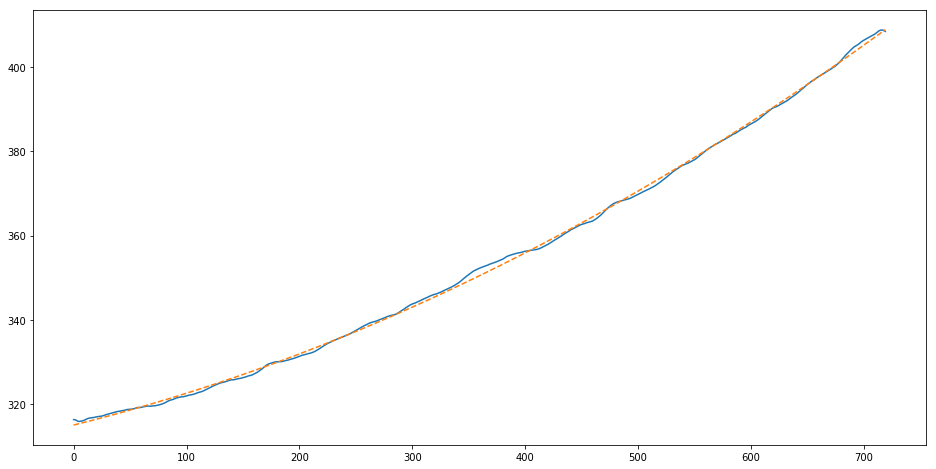

In [43]:
#Plot av regresjon linjen og dataene 
plt.figure(figsize=(16,8))
plt.plot(X, y,linestyle="-")
plt.plot(X, pred,linestyle="--")
plt.show()

In [44]:
def plot_df(df, x, y, title="", xlabel='Dato', ylabel='CO2[ppm]'):
    
    plt.figure(figsize=(16,8))
    plt.plot(x, y,linestyle="-")
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

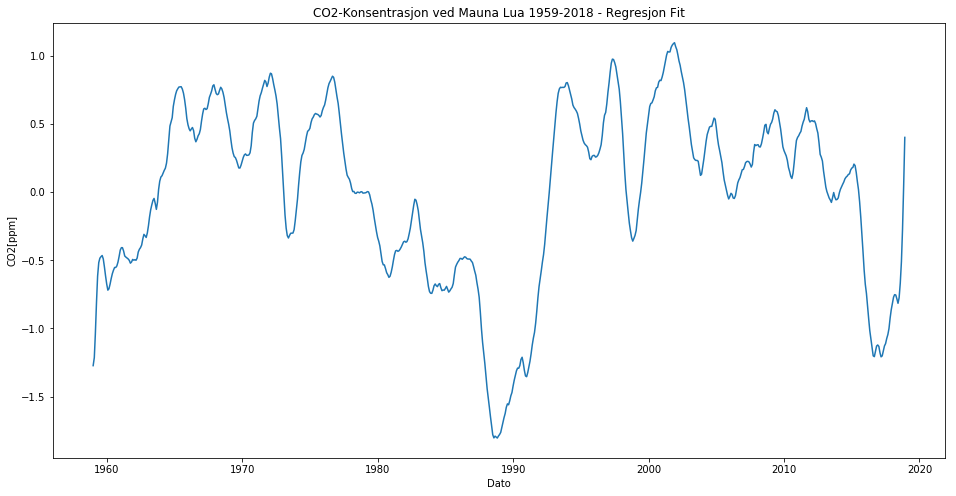

In [45]:
plot_df(dfz, x=dfz.index, y=dfz.CO2, title='CO2-Konsentrasjon ved Mauna Lua 1959-2018 - Regresjon Fit') 

In [46]:
def gen_autocorr(series):
    length_sequence = series.size
    lag = np.array(range(-length_sequence, length_sequence + 1))
    autocorr_residuals = np.zeros(2*length_sequence + 1)
    for l in lag:
        autocorr_residuals[l+length_sequence] = series.autocorr(lag=l)
    return lag, pd.Series(autocorr_residuals)
        
lag, autocorr_residuals = gen_autocorr(dfz.CO2)

/Users/Eirik/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/Eirik/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
